In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install tfa-nightly
!pip install import-ipynb
import import_ipynb
import tensorflow as tf
import numpy as np
import os
import scipy.io as sio
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from tqdm import tqdm
from fastprogress import master_bar, progress_bar
%cd '/content/drive/MyDrive/LMSLoss'

     |████████████████████████████████| 747kB 5.8MB/s 
  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=e4f090b6fca83beb33d6d3465802f4952b22b46cc7179cef28cf4e169af2741e
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb
/content/drive/MyDrive/LMSLoss


In [ ]:
%run UnetModel.ipynb
# %run MumfordLoss.ipynb
%run augment_data.ipynb


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 576         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
swish (Swish)                   (None, 128, 128, 64) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
import keras.backend as K

def dice_coef(y_true, y_pred, smooth=1e-10):
    '''Average dice coefficient per batch.'''
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes)
    summation = K.sum(y_true + y_pred, axis=axes)
    return K.mean((2.0 * intersection + smooth) / (summation + smooth), axis=0)

def jaccard_coef(y_true, y_pred, smooth=1e-10):
    '''Average jaccard coefficient per batch.'''
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes)
    union = K.sum(y_true + y_pred, axis=axes) - intersection
    return K.mean( (intersection + smooth) / (union + smooth), axis=0)

In [ ]:
x =  np.load("dataISIC2018/x.npy")
y = np.load("dataISIC2018/y.npy")
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state =42)
x_train=tf.convert_to_tensor(x_train,tf.float32)
y_train=tf.convert_to_tensor(y_train,tf.float32)
x_test=tf.convert_to_tensor(x_test,tf.float32)
y_test=tf.convert_to_tensor(y_test,tf.float32)


In [ ]:
BATCH_SIZE = 32
buffer_size = x_train.shape[0]

@tf.function
def gen_image(image,mask):
  # image, mask = brightness(image,mask)
  #image, mask = saturation(image,mask)
  image, mask = flip(image,mask)
  image, mask = rotate_image(image,mask)
  image, mask = normalize(image, mask)
  return image, mask
train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train)).shuffle(buffer_size).map(gen_image).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test,y_test)).map(normalize).batch(BATCH_SIZE*2)
# val_dataset = tf.data.Dataset.from_tensor_slices((x_val,y_val)).map(normalize).batch(BATCH_SIZE*2)

In [ ]:
class MSLoss_vs2():
  def levelsetLoss(self,target, output, kernel_size = 7):
    loss = 0.0
    yn = output
    # yn = output[...,:-1]
    # bn = output[...,-1:]
    kernel = tf.ones([kernel_size, kernel_size, 1, yn.shape[-1]],tf.float32) / (kernel_size**2)
    for ich in range(target.shape[-1]):
        target_ = target[...,ich:ich+1]    
        pcentroid_1 = tf.nn.conv2d( target_ * yn, kernel, strides=1, padding='SAME')
        pcentroid_2 =  tf.nn.conv2d(yn+1e-6, kernel, strides=1, padding='SAME')
        # pcentroid = tf.reduce_sum(pcentroid_1, (1,2),keepdims=True)/tf.reduce_sum(pcentroid_2 (1,2),keepdims = True)   
        pcentroid = pcentroid_1 / pcentroid_2
        plevel = target_ - pcentroid
        pLoss = plevel * plevel * yn
        loss += tf.reduce_sum(pLoss)
    return loss
      
  def activeContourLoss(self,y_true,y_pred,outDim =2,smooth=0.001):     
    yTrueOnehot = tf.one_hot(tf.squeeze(tf.cast(y_true,tf.uint8),axis=-1), depth = outDim)
    loss =  y_pred * (1-yTrueOnehot) + (1-y_pred)*yTrueOnehot
    return tf.reduce_mean(loss)
    #this is Luac:
    # loss =  - tf.cast(tf.math.log(1-y_pred+smooth),tf.float32) * (1-yTrueOnehot ) - tf.cast(tf.math.log(y_pred+smooth),tf.float32)*yTrueOnehot
    # return tf.reduce_mean(loss)
                    
  def gradientLoss(self,input,penalty = "l1"):

    dH = tf.math.abs(input[:, 1:, :, :] - input[:, :-1, :, :])
    dW = tf.math.abs(input[:, :, 1:, :] - input[:, :, :-1, :])
    if penalty == "l2":
        dH = dH * dH
        dW = dW * dW

    loss =  tf.reduce_sum(dH) +  tf.reduce_sum(dW)
    return loss

In [ ]:
class Mumford_Unet_vs2(MSLoss_vs2):
  def __init__(self,model):
    super().__init__()
    self.model = model
    self.optimizer = None
    self.trainData = None
    self.testData = None
    self.batch_size = BATCH_SIZE
    temp = x_train.shape[0] // self.batch_size
    self.train_step = temp + 1 if x_train.shape[0] % self.batch_size != 0 else temp
    self.learning_rate = 0.001

  def optimizer_fc(self,op_type = "adam", op_param = 0.005):
    if op_type == 'adam':
      self.optimizer =  tf.keras.optimizers.Adam(op_param)
    elif op_type == "nadam":
      self.optimizer =  tf.keras.optimizers.Nadam(op_param)

  def loss(self, image, output, trueLabel, alpha = 1e-3, beta = 0.001):
    print('\ractive loss: ',self.activeContourLoss(trueLabel, output),' leverset loss: ', self.levelsetLoss(image,output),'gradient loss: ', self.gradientLoss(output), end="")
    return alpha * ( self.levelsetLoss(image,output) + beta * self.gradientLoss(output)) + self.activeContourLoss(trueLabel, output)
    # return self.activeContourLoss(trueLabel, output)

  def metrics(self,y_true,y_pred):
    output_standard = tf.expand_dims(tf.argmax(y_pred,axis=-1),axis = -1)
    output_standard = tf.cast(output_standard,tf.float32)
    dice = dice_coef(y_true, output_standard)
    jaccard = jaccard_coef(y_true, output_standard)
    return dice, jaccard

  def evaluateTest(self,testDataset):
    test_dices =  []
    test_jaccards =  []
    for xBatchTest, yBatchTest in testDataset:
      yPredBatchTest = self.model(xBatchTest, training =False)
      diceTest, jaccardTest =  self.metrics(yBatchTest, yPredBatchTest)
      test_dices.append(diceTest)
      test_jaccards.append(jaccardTest)
    return np.mean(test_dices), np.mean(test_jaccards)

  def epoch_training(self,model,optimizer, trainDataset, testDataset, mb, stepTrain, alpha_loss, beta_loss):
    train_losses = []
    train_dices =  []
    train_jaccards =  []

    trainDataset = iter(trainDataset)  
    for _ in progress_bar(range(stepTrain),parent = mb):   
      with tf.GradientTape() as tape:
        image, y_true = next(trainDataset)
        y_pred = self.model(image, training = True)
        total_loss  =  self.loss(image, y_pred, y_true, alpha_loss, beta_loss)

      
      grad  = tape.gradient(total_loss, self.model.trainable_variables)
      optimizer.apply_gradients(zip(grad,self.model.trainable_variables))

      diceTrain, jaccardTrain =  self.metrics(y_true, y_pred)

      mb.child.comment = 'Train loss {:.4f}'.format(total_loss)

      train_losses.append(total_loss)
      train_dices.append(diceTrain)
      train_jaccards.append(jaccardTrain)

    trainLossMean = np.mean(train_losses)
    trainDiceMean = np.mean(train_dices)
    trainJaccardMean = np.mean(train_jaccards)

    testDiceMean, testJaccardMean = self.evaluateTest(testDataset)

    return trainLossMean, trainDiceMean, trainJaccardMean, testDiceMean, testJaccardMean


  def train(self,num_epoch, reduceLrEpoch=10 , earlyStoping=22, minLr=1e-5, alpha_loss= 1e-6, beta_loss = 1,checkpoint_prefix = "m"):
    mb = master_bar(range(num_epoch))
    epochs_list = []
    history = dict()
    training_losses = []
    trainDice_list = []
    trainJaccard_list = []
    testDice_list = []
    testJaccard_list = []
    # learningRate_list = []
    best_score  = 0
    count = 0
    for epoch in mb:
      count += 1
      epochs_list.append(epoch+1)

      trainLoss, trainDice, trainJaccard, testDice, testJaccard  \
      = self.epoch_training(self.model, self.optimizer, self.trainData, self.testData, mb, self.train_step, alpha_loss, beta_loss)

      mb.write('Finish train epoch {} with loss {:.4f} trainDice: {:.2f}, trainJaccard: {:.2f}, testDice: {:.2f},\
       testJaccard: {:.2f}'.format(epoch+1, trainLoss, trainDice, trainJaccard, testDice, testJaccard))

      training_losses.append(trainLoss)
      trainDice_list.append(trainDice)
      trainJaccard_list.append(trainJaccard)
      testDice_list.append(testDice)
      testJaccard_list.append(testJaccard)
      # learningRate_list.append(self.learning_rate)

      if count % reduceLrEpoch ==0 :
        self.learning_rate = self.learning_rate * 0.5
        if self.learning_rate < minLr:
          self.learning_rate = minLr
        print('learning rate is set to : ',self.learning_rate)
        self.optimizer.learning_rate.assign(self.learning_rate )
    
      mb.update_graph([[epochs_list, training_losses]], [0,num_epoch], [0,0.1])
      if count == earlyStoping :
        break
      ### Check point here ###
      ### Check point follow testDice ###
      if best_score < testDice:
          count = 0
          mb.write(">>> Improved Dice-score EPI from {:.4f} to {:.4f}".format(best_score, testDice))
          best_score = testDice
          self.model.save_weights(checkpoint_prefix.format(score=best_score))
    history['epoch'] = epochs_list
    history['train_loss'] = training_losses
    history['train_dice'] = trainDice_list
    history['train_jaccard'] = trainJaccard_list
    history['test_dice'] = testDice_list
    history['test_jaccard'] = testJaccard_list
    # history['lr'] = learningRate_list
    return history 

In [ ]:
S = seg_net((128,160,3),out_channels=2)
nhat = Mumford_Unet_vs2(S)
nhat.learning_rate = 0.001
nhat.trainData = train_dataset
nhat.testData = test_dataset
nhat.optimizer_fc(op_type = "nadam", op_param=nhat.learning_rate)

In [ ]:
history = nhat.train(300,alpha_loss=1e-6,beta_loss=1e-2,checkpoint_prefix="./weightISIC_LMS/ckpt_{score:.4f}.h5")

In [ ]:
# sio.savemat('./weightISIC_LMS/historyISIC_LMS1.mat',history)

In [ ]:
nhat.model.load_weights('/content/drive/MyDrive/LMSLoss/weightISIC_LMS/ckpt_0.8890.h5')

In [ ]:
nhat.evaluateTest(test_dataset)

(0.88897187, 0.8150766)

In [ ]:
x_test1 = x_test/255.0

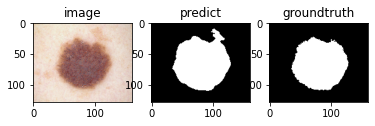

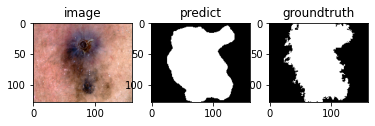

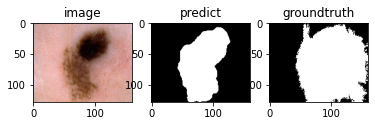

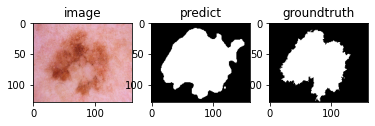

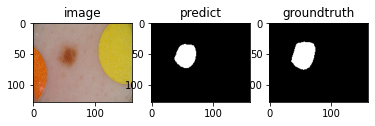

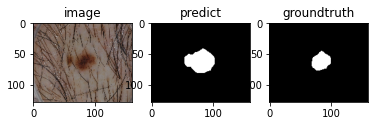

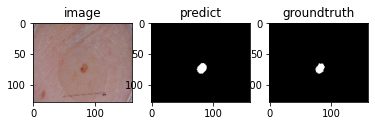

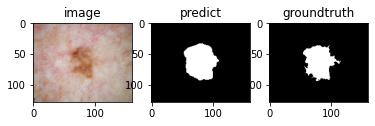

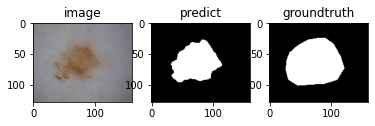

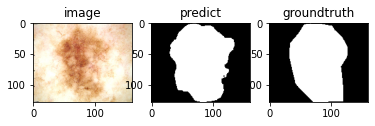

In [ ]:
for i in range(10):
  y_pred = nhat.model(x_test1[i:i+1])
  y_predShow = np.argmax(y_pred,axis = -1)
  plt.figure(i+1)
  plt.subplot(131),plt.imshow(tf.cast(x_test[i],tf.uint8)),plt.title('image')
  plt.subplot(132),plt.imshow(y_predShow[0],cmap ='gray'),plt.title('predict')
  plt.subplot(133),plt.imshow(y_test[i,...,0],cmap='gray'),plt.title('groundtruth')